<a href="https://colab.research.google.com/github/PierreBond/SP_PREDICTOR/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance tensorflow pandas numpy matplotlib textblob beautifulsoup4 requests

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
class StockPredictor:
    def __init__(self, ticker, seq_length=60, epochs=50):
        # Input validation
        if not isinstance(ticker, str) or len(ticker) == 0:
            raise ValueError("Ticker must be a non-empty string")
        self.ticker = ticker
        self.seq_length = seq_length
        self.epochs = epochs
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None
        self.data = None
        self.X_test = None
        self.y_test = None
        self.split_idx = None
        self.test_data = None  # Store aligned test data for plotting

    def fetch_data(self, start='2010-01-01', end='2023-12-31'):
        """Fetch OHLCV data with error handling."""
        try:
            self.data = yf.download(self.ticker, start=start, end=end)
            if self.data.empty:
                raise ValueError(f"No data found for ticker: {self.ticker}")
            self.data['Returns'] = self.data['Close'].pct_change()
            self.data['RSI'] = self._compute_rsi(self.data['Close'], window=14)
            self.data['MACD'] = self.data['Close'].ewm(span=12).mean() - self.data['Close'].ewm(span=26).mean()
            self.data.dropna(inplace=True)
            return self.data
        except Exception as e:
            print(f"Error fetching data: {str(e)}")
            raise

    def _compute_rsi(self, series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        return 100 - (100 / (1 + gain / loss))

    def preprocess_data(self):
        """Split before scaling to prevent leakage."""
        features = self.data[['Close', 'Returns', 'RSI', 'MACD', 'Volume']].values

        self.split_idx = int(0.8 * len(features))
        train_features, test_features = features[:self.split_idx], features[self.split_idx:]

        train_scaled = self.scaler.fit_transform(train_features)
        test_scaled = self.scaler.transform(test_features)

        X_train, y_train = self._create_sequences(train_scaled)
        X_test, y_test = self._create_sequences(test_scaled)

        self.X_test, self.y_test = X_test, y_test
        # Store aligned test data for plotting
        self.test_data = self.data.iloc[self.split_idx + self.seq_length:]
        return X_train, X_test, y_train, y_test

    def _create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            X.append(data[i:i+self.seq_length])
            y.append(data[i+self.seq_length, 0])
        return np.array(X), np.array(y)

    def create_model(self):
        """Simplified but effective LSTM with attention and regularization."""
        inputs = Input(shape=(self.seq_length, 5))

        # LSTM with attention
        x = LSTM(50, return_sequences=True, dropout=0.2)(inputs)
        x = MultiHeadAttention(num_heads=2, key_dim=32)(x, x)  # Reduced complexity
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)

        # Final layers
        x = LSTM(25, dropout=0.2)(x)
        outputs = Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='huber',
            metrics=['mae']
        )
        return model

    def train(self):
        X_train, X_test, y_train, y_test = self.preprocess_data()
        self.model = self.create_model()

        callbacks = [
            EarlyStopping(patience=15, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
        ]

        history = self.model.fit(
            X_train, y_train,
            epochs=self.epochs,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        return history

    def predict_with_uncertainty(self, n_samples=10):
        """Monte Carlo dropout for uncertainty estimation."""
        mc_predictions = np.stack([self.model.predict(self.X_test) for _ in range(n_samples)])
        mean = mc_predictions.mean(axis=0)
        std = mc_predictions.std(axis=0)
        return mean, std

    def backtest(self, predictions):
        """Properly aligned backtesting with correct indexing."""
        test_prices = self.test_data['Close'].values

        # Align predictions (remove first prediction)
        aligned_preds = predictions[:-1]

        # Calculate returns
        returns = test_prices[1:] / test_prices[:-1] - 1

        # Generate signals
        signals = np.where(aligned_preds > test_prices[:-1], 1, -1)

        # Apply transaction costs
        strategy_returns = signals * returns - 0.001

        # Calculate metrics
        sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
        max_drawdown = (np.maximum.accumulate(1+strategy_returns) - (1+strategy_returns)).max()

        return sharpe, max_drawdown

    def plot_results(self):
        """Plot with properly aligned data and robust uncertainty bands."""
        if self.test_data is None:
            raise ValueError("Test data not available. Run preprocess_data() first.")

        pred_mean, pred_std = self.predict_with_uncertainty()

        # Create inverse-transform compatible arrays
        def inverse_transform_single_dim(values):
            dummy = np.zeros((len(values), 5))
            dummy[:, 0] = values.flatten()
            return self.scaler.inverse_transform(dummy)[:, 0]

        # Calculate uncertainty bounds
        pred_close = inverse_transform_single_dim(pred_mean)
        upper = inverse_transform_single_dim(pred_mean + pred_std)
        lower = inverse_transform_single_dim(pred_mean - pred_std)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

        # Price plot
        ax1.plot(self.test_data.index, self.test_data['Close'].values,
                label='True Price', linewidth=2)
        ax1.plot(self.test_data.index, pred_close, label='Predicted', alpha=0.8)
        ax1.fill_between(self.test_data.index, lower, upper, alpha=0.3,
                        label='Uncertainty (±1σ)')
        ax1.set_title(f"{self.ticker} Stock Price Prediction")
        ax1.set_ylabel("Price ($)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Returns distribution
        test_returns = self.test_data['Returns'].values
        ax2.hist(test_returns, bins=50, alpha=0.7,
                edgecolor='black', color='skyblue')
        ax2.axvline(np.mean(test_returns), color='red', linestyle='--',
                   label=f'Mean: {np.mean(test_returns):.2%}')
        ax2.set_title("Returns Distribution")
        ax2.set_ylabel("Frequency")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

In [3]:
# Initialize and train the model
try:
    predictor = StockPredictor("AAPL", seq_length=60, epochs=30)  # Reduced epochs for faster execution
    predictor.fetch_data()
    history = predictor.train()
    print("Model training completed!")
except Exception as e:
    print(f"Error: {str(e)}")

/tmp/ipython-input-713803070.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - loss: 0.0619 - mae: 0.2594 - val_loss: 0.0964 - val_mae: 0.4235 - learning_rate: 1.0000e-04
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0123 - mae: 0.1147 - val_loss: 0.0415 - val_mae: 0.2666 - learning_rate: 1.0000e-04
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0105 - mae: 0.0966 - val_loss: 0.0319 - val_mae: 0.2298 - learning_rate: 1.0000e-04
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0086 - mae: 0.0880 - val_loss: 0.0267 - val_mae: 0.2066 - learning_rate: 1.0000e-04
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0078 - mae: 0.0842 - val_loss: 0.0196 - val_mae: 0.1713 - learning_rate: 1.0000e-04
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0066 - mae: 0.0763 - val_loss: 0.0210 - val_mae: 0.1786 - learning_rate: 1.0000e-04
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0063 - mae: 0.0731 - val_loss: 0.0215 - val_mae: 0.1811 - learnin

In [4]:
# Evaluate the model
try:
    pred_mean, _ = predictor.predict_with_uncertainty()
    sharpe, drawdown = predictor.backtest(pred_mean)
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {drawdown:.2%}")
except Exception as e:
    print(f"Error during evaluation: {str(e)}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sharpe Ratio: -1.62
Max Drawdown: 14.77%


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


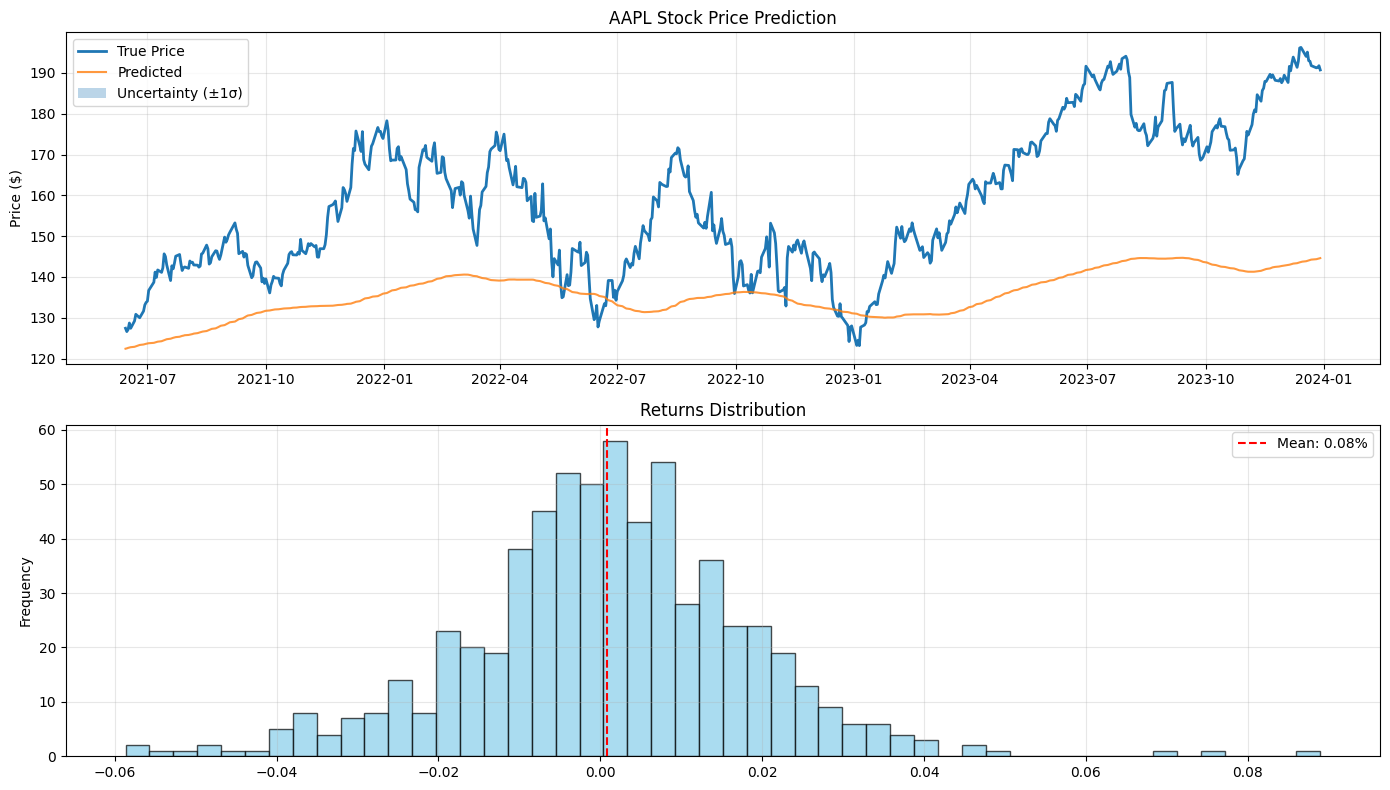

In [5]:
# Plot results
try:
    fig = predictor.plot_results()
    plt.show()
except Exception as e:
    print(f"Error during plotting: {str(e)}")

In [7]:
# Most robust evaluation method
def evaluate_model(predictor):
    try:
        # Get predictions
        pred_mean, _ = predictor.predict_with_uncertainty()

        # Get test data
        test_data = predictor.test_data['Close'].values

        # Align data properly
        min_len = min(len(pred_mean), len(test_data))
        pred_mean = pred_mean[:min_len]
        test_data = test_data[:min_len]

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test_data, pred_mean))
        mae = np.mean(np.abs(test_data - pred_mean))
        ss_total = np.sum((test_data - np.mean(test_data)) ** 2)
        ss_residual = np.sum((test_data - pred_mean) ** 2)
        r2 = 1 - (ss_residual / ss_total)

        print(f"Root Mean Squared Error: ${rmse:.2f}")
        print(f"Mean Absolute Error: ${mae:.2f}")
        print(f"R-squared: {r2:.4f}")

        return rmse, mae, r2

    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return None

# Run evaluation
try:
    metrics = evaluate_model(predictor)
except Exception as e:
    print(f"Error: {str(e)}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Root Mean Squared Error: $158.25
Mean Absolute Error: $157.28
R-squared: -80.3945


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Trading Strategy Performance:
Total Return: -71.07%
Annual Return: -38.59%
Sharpe Ratio: -1.62
Max Drawdown: 14.77%


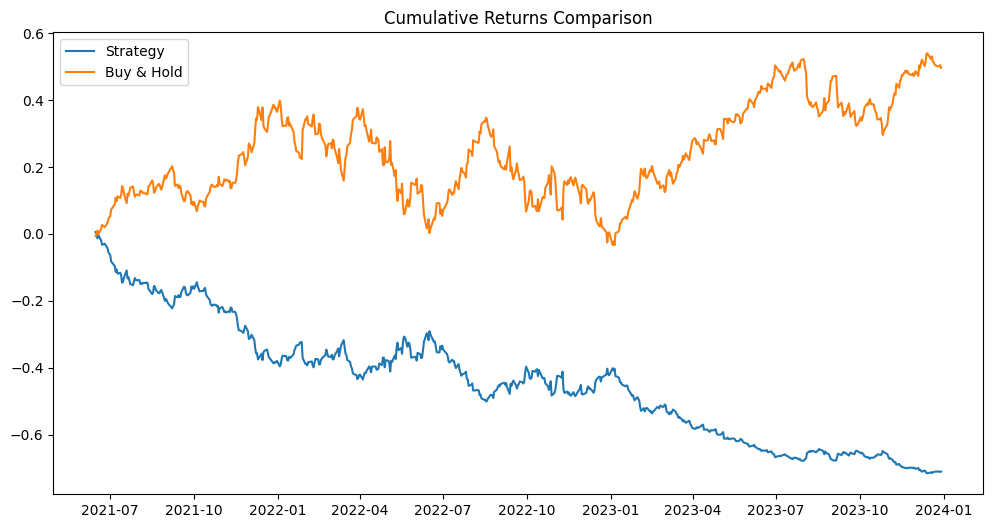

In [8]:
def evaluate_trading_strategy(predictor, predictions):
    """Evaluate how well predictions translate to trading profits."""
    try:
        # Get aligned test data
        test_prices = predictor.test_data['Close'].values

        # Generate trading signals
        signals = np.where(predictions[:-1] > test_prices[:-1], 1, -1)

        # Calculate returns
        returns = test_prices[1:] / test_prices[:-1] - 1
        strategy_returns = signals * returns - 0.001  # Include transaction costs

        # Calculate performance metrics
        total_return = np.prod(1 + strategy_returns) - 1
        annual_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
        sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
        max_drawdown = (np.maximum.accumulate(1 + strategy_returns) - (1 + strategy_returns)).max()

        print("\nTrading Strategy Performance:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Annual Return: {annual_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")

        # Plot cumulative returns
        cumulative_strategy = np.cumprod(1 + strategy_returns) - 1
        cumulative_buy_hold = np.cumprod(1 + returns) - 1

        plt.figure(figsize=(12, 6))
        plt.plot(predictor.test_data.index[1:], cumulative_strategy, label='Strategy')
        plt.plot(predictor.test_data.index[1:], cumulative_buy_hold, label='Buy & Hold')
        plt.title("Cumulative Returns Comparison")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error evaluating trading strategy: {str(e)}")

# Evaluate trading performance
try:
    pred_mean, _ = predictor.predict_with_uncertainty()
    evaluate_trading_strategy(predictor, pred_mean)
except Exception as e:
    print(f"Error during strategy evaluation: {str(e)}")